In [8]:
#""Aggregation cost functions. Determine the cost of cluster heads for   warding messages."""
def zero_cost_aggregation(msg_length):
    return 0

def total_cost_aggregation(msg_length):
    return msg_length

def linear_cost_aggregation(factor):
  #"""Defines a family of functions."""
    return lambda x: int(x*factor)

def log_cost_aggregation(msg_length):
    return int(math.log(msg_length))

In [11]:
import config as cf
import logging

class EnergySource(object):
    def __init__(self, parent):
        self.energy = cf.INITIAL_ENERGY
        self.node = parent

    def recharge(self):
        self.energy = cf.INITIAL_ENERGY

class Battery(EnergySource):
    def consume(self, energy):
        if self.energy >= energy:
            self.energy -= energy
        else:
            logging.info("node %d: battery is depleted." % (self.node.id))
            self.energy = 0

        self.node.battery_depletion()

class PluggedIn(EnergySource):
    def consume(self, energy):
        pass

In [ ]:
import config as cf
import logging
from python.network.node import *
from python.utils.grid import *
import matplotlib.pyplot as plt
from python.utils.utils import *
from python.utils.tracer import *
from python.sleep_scheduling.sleep_scheduler import *
from multiprocessing.dummy import Pool as ThreadPool

class Network(list):
  """This class stores a list with all network nodes plus the base sta-
  tion. Its methods ensure the network behavior.
  """
  def __init__(self, init_nodes=None):
    logging.debug('Instantiating nodes...')
    if init_nodes:
      self.extend(init_nodes)
    else:
      nodes = [Node(i, self) for i in range(0, cf.NB_NODES)]
      self.extend(nodes)
      # last node in nodes is the base station
      base_station = Node(cf.BSID, self)
      base_station.pos_x = cf.BS_POS_X
      base_station.pos_y = cf.BS_POS_Y
      self.append(base_station)
    
    self._dict = {}
    for node in self:
      self._dict[node.id] = node

    self.perform_two_level_comm = 1
    self.round = 0
    self.centroids = []
    self.routing_protocol = None
    self.sleep_scheduler_class = None

    self.initial_energy = self.get_remaining_energy()
    self.first_depletion = 0
    self.per30_depletion = 0
    self.energy_spent = []

  def reset(self):
    """Set nodes to initial state so the same placement of nodes can be
    used by different techniques.
    """
    for node in self:
      node.energy_source.recharge()
      node.reactivate()

    # allows for updates of BS position between simulations
    self[-1].pos_x = cf.BS_POS_X
    self[-1].pos_y = cf.BS_POS_Y

    self.round = 0
    self.centroids = []
    self.energy_spent = []

    self.routing_protocol = None
    self.sleep_scheduler_class = None

    self.first_depletion = 0
    self.per30_depletion = 0
    self.perform_two_level_comm = 1

  def simulate(self):
    tracer = Tracer()

    self.routing_protocol.pre_communication(self)

    all_alive = 1
    percent70_alive = 1
    self.deaths_this_round = 0

    if self.sleep_scheduler_class:
      self._sleep_scheduler = SleepScheduler(self, self.sleep_scheduler_class)

    for round_nb in range(0, cf.MAX_ROUNDS):
      self.round = round_nb
      print_args = (round_nb, self.get_remaining_energy())
      print("round %d: total remaining energy: %f" % print_args)
      nb_alive_nodes = self.count_alive_nodes()
      if nb_alive_nodes == 0:
        break
      tracer['alive_nodes'][2].append(nb_alive_nodes)
      if cf.TRACE_ENERGY:
        tracer['energies'][2].append(self.get_remaining_energy())

      if self.sleep_scheduler_class:
        log = self._sleep_scheduler.schedule()
        for key, value in log.iteritems():
          tracer[key][2].append(value)

      self.routing_protocol.setup_phase(self, round_nb)

      # check if someone died
      if self.deaths_this_round != 0:
        if all_alive == 1:
          all_alive = 0
          self.first_depletion = round_nb
        if float(nb_alive_nodes)/float(cf.NB_NODES) < 0.7 and \
           percent70_alive == 1:
          percent70_alive = 0
          self.per30_depletion = round_nb

      # clears dead counter
      self.deaths_this_round = 0
      self.routing_protocol.broadcast(self)

      self._run_round(round_nb)

    tracer['first_depletion'][2].append(self.first_depletion)
    tracer['30per_depletion'][2].append(self.per30_depletion)

    return tracer

  def _run_round(self, round):
    """Run one round. Every node captures using its sensor. Then this
    information is forwarded through the intermediary nodes to the base
    station.
    """
    before_energy = self.get_remaining_energy()
    for i in range(0, cf.MAX_TX_PER_ROUND):
      self._sensing_phase()
      self._communication_phase()
    after_energy = self.get_remaining_energy()
    self.energy_spent.append(before_energy - after_energy)

  def _sensing_phase(self):
    """Every alive node captures information using its sensor."""
    for node in self.get_alive_nodes():
      node.sense()

  def _communication_phase(self):
    """Each node transmits respecting its hierarchy: leaves start the 
    communication, then cluster heads forward the messages, until all
    messages reach the base station. This method works for any hierar-
    chy (even for LEACH).
    """
    #ordinary_nodes = self.get_ordinary_nodes()
    #heads = self.get_ch_nodes()
    #msg = str("%d ordinary nodes, %d heads." % (len(ordinary_nodes), len(heads)))
    #logging.debug("Hierarchical communication: %s" % (msg))

    alive_nodes = self.get_alive_nodes()
    if self.perform_two_level_comm == 1:
      self._two_level_comm(alive_nodes)
    else:
      self._recursive_comm(alive_nodes)

  def _recursive_comm(self, alive_nodes):
    """Hierarchical communication using recursivity. This method suppo-
    ses that there is no cycle in the network (network is a tree).
    Otherwise, expect infinite loop.
    """
    next_alive_nodes = alive_nodes[:]
    for node in alive_nodes:
      #check if other nodes must send info to this node
      depends_on_other_node = 0
      for other_node in alive_nodes:
        #if other_node == node:
        #  continue
        if other_node.next_hop == node.id:
          depends_on_other_node = 1
          break

      if not depends_on_other_node:
        node.transmit()
        next_alive_nodes = [n for n in next_alive_nodes if n != node]

    if len(next_alive_nodes) == 0:
      return
    else:
      self._recursive_comm(next_alive_nodes)

  def _two_level_comm(self, alive_nodes):
    """This method performs communication supposing that there are only
    ordinary nodes and cluster heads, this method is less generic than
    its recursive version, but it is faster.
    """
    # heads wait for all ordinary nodes, then transmit to BS
    for node in self.get_ordinary_nodes():
      node.transmit()
    for node in self.get_heads():
      node.transmit()

  def get_alive_nodes(self):
    """Return nodes that have positive remaining energy."""
    return [node for node in self[0:-1] if node.alive]

  def get_active_nodes(self):
    """Return nodes that have positive remaining energy and that are
    awake."""
    is_active = lambda x: x.alive and not x.is_sleeping
    return [node for node in self[0:-1] if is_active(node)]

  def get_ordinary_nodes(self):
    return [node for node in self if node.is_ordinary() and node.alive]

  def get_heads(self, only_alives=1):
    input_set = self.get_alive_nodes() if only_alives else self
    return [node for node in input_set if node.is_head()]

  def get_sensor_nodes(self):
    """Return all nodes except base station."""
    return [node for node in self[0:-1]]

  def get_average_energy(self):
    return np.average(self.energy_spent)

  def someone_alive(self):
    """Finds if there is at least one node alive. It excludes the base station,
       which is supposed to be always alive."""
    for node in self[0:-1]:
      if node.alive == 1:
        return 1
    return 0

  def count_alive_nodes(self):
    return sum(x.alive for x in self[:-1])

  def get_BS(self):
    # intention: make code clearer for non-Python readers
    return self[-1]

  def get_node(self, id):
    """By default, we assume that the id is equal to the node's posi-
    tion in the list, but that may not be always the case.
    """
    return self._dict[id]

  def notify_position(self):
    """Every node transmit its position directly to the base station."""
    for node in self.get_alive_nodes():
      node.transmit(msg_length=cf.MSG_LENGTH, destination=self.get_BS())

  def broadcast_next_hop(self):
    """Base station informs nodes about their next hop."""
    base_station = self.get_BS()
    for node in self.get_alive_nodes():
      base_station.transmit(msg_length=cf.MSG_LENGTH, destination=node)

  def get_nodes_by_membership(self, membership, only_alives=1):
    """Returns all nodes that belong to this membership/cluster."""
    input_set = self.get_alive_nodes() if only_alives else self
    condition = lambda node: node.membership == membership and node.id != cf.BSID
    return [node for node in input_set if condition(node)]

  def get_remaining_energy(self, ignore_nodes=None):
    """Returns the sum of the remaining energies at all nodes."""
    set = self.get_alive_nodes()
    if len(set) == 0:
      return 0
    if ignore_nodes:
      set = [node for node in set if node not in ignore_nodes]
    transform = lambda x: x.energy_source.energy
    energies = [transform(x) for x in set]
    return sum(x for x in energies)

  def set_aggregation_function(self, function):
    """Sets the function that determines the cost of aggregation."""
    for node in self:
      node.aggregation_function = function
    
  def split_in_clusters(self, nb_clusters=cf.NB_CLUSTERS):
    """Split this nodes object into other nodes objects that contain only
    information about a single cluster."""
    clusters = []
    for cluster_idx in range(0, nb_clusters):
      nodes = self.get_nodes_by_membership(cluster_idx)
      cluster = Network(init_nodes=nodes)
      cluster.append(self.get_BS())
      clusters.append(cluster)
    return clusters

  def _calculate_nb_neighbors(self, target_node):
    """Calculate the number of neighbors given the sensor coverage
    radius.
    """
    # if number of neighbors was calculated at least once
    # skips calculating the distance
    if target_node.nb_neighbors != -1:
      # only check if there are dead nodes
      all_neighbors = target_node.neighbors
      nb_dead_neighbors = sum(1 for x in all_neighbors if not x.alive)
      target_node.neighbors[:] = [x for x in all_neighbors if x.alive]
      return target_node.nb_neighbors - nb_dead_neighbors

    nb_neighbors = 0
    shortest_distance = cf.COVERAGE_RADIUS*2
    for node in self.get_alive_nodes():
      if node == target_node:
        continue
      distance = calculate_distance(target_node, node)
      if distance <= cf.COVERAGE_RADIUS:
        nb_neighbors += 1
        target_node.neighbors.append(node) 
        if distance < shortest_distance:
          shortest_distance = distance

    if shortest_distance != cf.INFINITY:
      exclusive_radius = shortest_distance - cf.COVERAGE_RADIUS
      if exclusive_radius < 0:
        exclusive_radius = 0.0
    
    node.nb_neighbors = nb_neighbors
    node.exclusive_radius = exclusive_radius

  def update_neighbors(self):
    for node in self.get_alive_nodes():
      self._calculate_nb_neighbors(node)

    self.update_sleep_prob()

  def update_sleep_prob(self):
    for node in self.get_alive_nodes():
      node.update_sleep_prob()

In [12]:
import config as cf
import numpy as np
from python.network.energy_source import *
from python.utils.utils import *

class Node(object):
  def __init__(self, id, parent = None):
    self.pos_x = np.random.uniform(0, cf.AREA_WIDTH)
    self.pos_y = np.random.uniform(0, cf.AREA_LENGTH)

    if id == cf.BSID:
      self.energy_source = PluggedIn(self)
    else:
      self.energy_source = Battery(self)

    self.id = id
    self.network_handler = parent

    self.reactivate()

  def reactivate(self):
    """Reactivate nodes for next simulation."""
    self.alive = 1
    self.tx_queue_size = 0
    self._next_hop = cf.BSID
    self.distance_to_endpoint = 0
    self.amount_sensed = 0
    self.amount_transmitted = 0
    self.amount_received = 0
    self.membership = cf.BSID
    # aggregation function determines the cost of forwarding messages
    # (in number of bits)
    self.aggregation_function = lambda x: 0
    self.time_of_death = cf.INFINITY
    self._is_sleeping = 0
    self.sleep_prob = 0.0
    # for coverage purposes
    self.neighbors = []
    self.nb_neighbors = -1
    self.exclusive_radius = 0

  @property
  def next_hop(self):
    return self._next_hop

  @next_hop.setter
  def next_hop(self, value):
    self._next_hop = value
    distance = calculate_distance(self, self.network_handler[value])
    self.distance_to_endpoint = distance

  @property
  def is_sleeping(self):
    if self.is_head():
      self._is_sleeping = 0
    return self._is_sleeping

  @is_sleeping.setter
  def is_sleeping(self, value):
    """Cluster heads cannot be put to sleep."""
    self._is_sleeping = value if not self.is_head() else 0
    
  def _only_active_nodes(func):
    """This is a decorator. It wraps all energy consuming methods to
    ensure that only active nodes execute this method. Also it automa-
    tically calls the battery. 
    """
    def wrapper(self, *args, **kwargs):
      if self.alive and not self.is_sleeping:
        func(self, *args, **kwargs)
        return 1
      else:
        return 0
    return wrapper

  @_only_active_nodes
  def update_sleep_prob(self):
    """Update the sleep probability. This method supposes that the
    endpoint is the cluster head
    """
    # cluster heads should not go to sleep. Neither dead nodes.
    if self.next_hop == cf.BSID:
      self.sleep_prob = 0.0
    else:
      self.sleep_prob = 0.5

    return

  @_only_active_nodes
  def update_sleep_prob2(self, nb_neighbors):
    """Updates the sleep probability according to paper X."""
    if self.next_hop == cf.BSID:
      self.sleep_prob = 0.0
    if nb_neighbors == 0:
      term1 = 0
    else:
      term1 = PSO_E*(nb_neighbors-1)/nb_neighbors
    if self.distance_to_endpoint == 0:
      term2 = 0
    else:
      term2 = PSO_F*(self.distance_to_endpoint-1)/self.distance_to_endpoint
    self.sleep_prob = term1 + term2

  def is_head(self):
    if self.next_hop == cf.BSID and self.id != cf.BSID and self.alive:
      return 1
    return 0

  def is_ordinary(self):
    return 1 if self.next_hop != cf.BSID and self.id != cf.BSID else 0

  @_only_active_nodes
  def _aggregate(self, msg_length):
    logging.debug("node %d aggregating." % (self.id))
    # number of bits to be sent increase while forwarding messages
    aggregation_cost = self.aggregation_function(msg_length)
    self.tx_queue_size += aggregation_cost

    # energy model for aggregation
    energy = cf.E_DA * aggregation_cost
    self.energy_source.consume(energy)

  @_only_active_nodes
  def transmit(self, msg_length=None, destination=None):
    logging.debug("node %d transmitting." % (self.id))
    if not msg_length:
      msg_length = self.tx_queue_size
    msg_length += cf.HEADER_LENGTH

    if not destination:
      destination = self.network_handler[self.next_hop]
      distance = self.distance_to_endpoint
    else:
      distance = calculate_distance(self, destination)

    # transmitter energy model
    energy = cf.E_ELEC
    if distance > cf.THRESHOLD_DIST:
      energy += cf.E_MP * (distance**4)
    else:
      energy += cf.E_FS * (distance**2)
    energy *= msg_length

    # automatically call other endpoint receive
    destination.receive(msg_length)
    # after the message is sent, queue is emptied 
    self.tx_queue_size = 0
    self.amount_transmitted += msg_length

    self.energy_source.consume(energy)

  @_only_active_nodes
  def receive(self, msg_length):
    logging.debug("node %d receiving." % (self.id))
    self._aggregate(msg_length - cf.HEADER_LENGTH)

    self.amount_received += msg_length

    # energy model for receiver
    energy = cf.E_ELEC * msg_length
    self.energy_source.consume(energy)

  @_only_active_nodes
  def sense(self):
    self.tx_queue_size = cf.MSG_LENGTH
    self.amount_sensed += cf.MSG_LENGTH

  def battery_depletion(self):
    self.alive = 0
    self.sleep_prob = 0.0
    self.time_of_death = self.network_handler.round
    self.network_handler.deaths_this_round += 1


ModuleNotFoundError: No module named 'python'

In [35]:
# Dijkstra's algorithm for shortest paths
# David Eppstein, UC Irvine, 4 April 2002

# http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/117228
from python.routing.priodict import priorityDictionary

def Dijkstra(G,start,end=None):
  #"""
 # Find shortest paths from the  start vertex to all vertices nearer than or equal to the end.
  #The input graph G is assumed to have the following representation:
 # A vertex can be any object that can be used as an index into a dictionary.
 # G is a dictionary, indexed by vertices.  For any vertex v, G[v] is itself a dictionary,
##  indexed by the neighbors of v.  For any edge v->w, G[v][w] is the length of the edge.
#  This is related to the representation in <http://www.python.org/doc/essays/graphs.html>
 # where Guido van Rossum suggests representing graphs as dictionaries mapping vertices
 ### and they allow easy modification of the graph structure by edge insertion and removal.
 # Such modifications are not needed here but are important in many other graph algorithms.
 # Since dictionaries obey iterator protocol, a graph represented as described here could
 # be handed without modification to an algorithm expecting Guido's graph representation.
  #Of course, G and G[v] need not be actual Python dict objects, they can be any other
 #3 type of object that obeys dict protocol, for instance one could use a wrapper in which vertices
 # are URLs of web pages and a call to G[v] loads the web page and finds its outgoing links.
  
  #The output is a pair (D,P) where D[v] is the distance from start to v and P[v] is the
 # predecessor of v along the shortest path from s to v.
  
  #Dijkstra's algorithm is only guaranteed to work correctly when all edge lengths are positive.
  #This code does not verify this property for all edges (only the edges examined until the end
  #vertex is reached), but will correctly compute shortest paths even for some graphs with negative
 # edges, and will raise an exception if it discovers that a negative edge has caused it to make a mistake.
  #"""

    D = {}  # dictionary of final distances
    P = {}  # dictionary of predecessors
    Q = priorityDictionary()  # estimated distances of non-final vertices
    Q[start] = 0
  
    for v in Q:
        D[v] = Q[v]
        if v == end: break
    
    for w in G[v]:
        vwLength = D[v] + G[v][w]
        if w in D:
            if vwLength < D[w]:
                 raise ValueError("Dijkstra: found better path to already-final vertex")
            elif w not in Q or vwLength < Q[w]:
                 Q[w] = vwLength
                 P[w] = v
  
    return (D,P)
      
def shortestPath(G,start,end):
  #"""
 # Find a single shortest path from the given start vertex to the given end vertex.
  #The input has the same conventions as Dijkstra().
 # The output is a list of the vertices in order along the shortest path.
 # """

      D,P = Dijkstra(G,start,end)
      Path = []
      while 1:
             Path.append(end)
             if end == start: break
             end = P[end]
             Path.reverse()
      return Path

ModuleNotFoundError: No module named 'python'

In [13]:
import logging, sys
import config as cf

from python.routing.routing_protocol import *

class DC(RoutingProtocol):
    def pre_communication(self, network):
   # """Setup all the point-to-point connections for the direct communica-tion scenario. In this scenario, the setup is executed only once, and
    #all nodes send information directly to the base station.
    #"" "
        logging.info('Direct Communication: Setup phase')
        for node in network:
            node.next_hop = cf.BSID

    def broadcast(self, network):
        pass


ModuleNotFoundError: No module named 'python'

In [37]:
### import skfuzzy
import numpy as np
import logging, sys

from python.routing.mte import *
from python.utils.utils import *
from python.network.node import *
from python.network.network import Network
from python.routing.routing_protocol import *
from python.sleep_scheduling.sleep_scheduler import *
import config as cf

#"""Every node communicate its position to the base station. Then the 
#BS uses FCM to define clusters and broadcast this information to the
#network. Finally, a round is executed.
#"""
class FCM(RoutingProtocol):

  #def _initial_setup(self, network):
  def _setup_phase(self, network):
    #"""The base station uses Fuzzy C-Means to clusterize the network. The
   # optimal number of clusters is calculated. Then FCM is used to select
    ###eferece:
      #D. C. Hoang, R. Kumar and S. K. Panda, "Fuzzy C-Means clustering 
      #protocol for Wireless Sensor Networks," 2010 IEEE International 
     # Symposium on Industrial Electronics, Bari, 2010, pp. 3477-3482.
    #"""
    logging.debug('FCM: setup phase')
  
    sensor_nodes = network.get_sensor_nodes()
    # calculate the average distance to the BS
    transform = lambda node: calculate_distance(node, network.get_BS())
    distances_to_BS = [transform(node) for node in sensor_nodes]
    avg_distance_to_BS = np.average(distances_to_BS)
    nb_clusters = calculate_nb_clusters(avg_distance_to_BS)
    # using a constant because calculating this value on-the-fly gives
    # different result than the paper
    nb_clusters = cf.NB_CLUSTERS
  
    # format data to shape expected by skfuzzy API
    data = [[node.pos_x, node.pos_y] for node in network[0:-1]]
    data = np.array(data).transpose()
    centroids, membership = skfuzzy.cluster.cmeans(data, nb_clusters,
                                                   cf.FUZZY_M, error=0.005,
                                                   maxiter=1000, 
                                                   init=None)[0:2]
    # assign node nearest to centroid as cluster head
    heads = []
    # also annotates centroids to network
    network.centroids = []
    for cluster_id, centroid in enumerate(centroids):
      tmp_centroid = Node(0)
      tmp_centroid.pos_x = centroid[0]
      tmp_centroid.pos_y = centroid[1]
      network.centroids.append(tmp_centroid)
      nearest_node = None
      shortest_distance = cf.INFINITY
      for node in network[0:-1]:
        distance = calculate_distance(node, tmp_centroid)
        if distance < shortest_distance:
          nearest_node      = node
          shortest_distance = distance
      nearest_node.next_hop   = cf.BSID
      nearest_node.membership = cluster_id
      heads.append(nearest_node)
  
    # assign ordinary network to cluster heads using fcm
    for i, node in enumerate(network[0:-1]):
      if node in heads: # node is already a cluster head
        continue
      cluster_id      = np.argmax(membership[:,i])
      node.membership = cluster_id
      head = [x for x in heads if x.membership == cluster_id][0]
      node.next_hop   = head.id

    self.head_rotation(network)
  
  #def _setup_phase(self, network):
  def head_rotation(self, network):
    logging.debug('FCM: head rotation')
    # head rotation
    # current cluster heads choose next cluster head with the most
    # residual energy and nearest to the cluster centroid
    for cluster_id in range(0, cf.NB_CLUSTERS):
      cluster = network.get_nodes_by_membership(cluster_id)
      # check if there is someone alive in this cluster
      if len(cluster) == 0:
        continue
  
      # someone is alive, find node with highest energy in the cluster
      # to be the next cluster head
      highest_energy = cf.MINUS_INFINITY
      next_head      = None
      for node in cluster:
        if node.energy_source.energy > highest_energy:
          highest_energy = node.energy_source.energy
          next_head      = node
  
      for node in cluster:
        node.next_hop = next_head.id
      next_head.next_hop = cf.BSID


# code temporary ommited
#def FCM_MTE_round(network, round_nb, local_traces=None, ret=None):
#  """Every node communicate its position to the base station. Then the 
#  BS uses FCM to define clusters and broadcast this information to the
#  network. Finally, a round is executed.
#  """
  setup_phase_fcm(network, round_nb)
  heads = Network(init_network=network.get_heads()+[network.get_BS()])
  setup_phase_mte(heads)
  network.broadcast_next_hop()
  network.run_round(round_nb)


#def FCM_PSO_round(network, round_nb, local_traces=None, sleep_schedulers=None):
#  """Every node communicate its position to the base station. Then the 
#  BS uses FCM to define clusters and broadcast this information to the
#  network. Finally, a round is executed.
#  """
   setup_phase_fcm(network, round_nb)
 if round_nb == 0: # clusters do not change in FCM
    clusters         = network.split_in_clusters()
    sleep_schedulers = [SleepScheduler(cluster) for cluster in clusters]

  for sleep_scheduler in sleep_schedulers:
    sleep_scheduler.schedule()
  network.run_round(round_nb)

  return sleep_schedulers

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 123)

In [ ]:
# -*- coding: utf-8 -*-
import logging, sys
from python.routing.dijkstra import *
from python.utils.utils import *
from python.network.node import *
from python.network.network import Network
from python.routing.routing_protocol import *
import config as cf

class MTE(RoutingProtocol):
  def _find_shortest_path(self, network):
    """The base station decides the next-hop for every node using
    Dijkstra's algorithm (shortest path). Then it broadcasts this infor-
    mation to all network. This function builds a graph with weights/cost
    related to each pair of network. The weights are not the Euclidean dis-
    nces, but rather a funcion of distances. If the distance is greater
    than THRESHOLD_DIST d^4 i used, otherwise d^2 is used. This comes
    from the energy model (see reference).
    Reference:
      M. Ettus. System Capacity, Latency, and Power Consumption in Multi-
      hop-routed SS-CDMA Wireless Networks. In Radio and Wireless Confe-
      rence (RAWCON 98), pages 55–58, Aug. 1998
    """
    logging.info('MTE: setup phase')
  
    # generate cost graph only for alive network (in dict form):
    # origin_id: {dest_id1: cost1, dest_id2: cost2, ...}, ...
    alive_nodes = network.get_alive_nodes()
    alive_nodes_and_BS = alive_nodes + [network.get_BS()]
    G = {}
    for node in alive_nodes_and_BS:
      G[node.id] = {}
      for other in alive_nodes_and_BS:
        if other == node:
          continue
        distance = calculate_distance(node, other)
        cost = distance**2 if distance < cf.THRESHOLD_DIST else distance**4
        G[node.id][other.id] = cost
  
    # calculate shortest path and set next_hop accordingly
    done = []
    while len(alive_nodes) != 0:
      starting_node = alive_nodes[0]
      shortest_path = shortestPath(G, starting_node.id, cf.BSID)
      for i, id in enumerate(shortest_path):
        if id == cf.BSID or id in done:
          break
        network.get_node(id).next_hop = shortest_path[i+1]
        #network[id].next_hop = shortest_path[i+1]
        alive_nodes = [node for node in alive_nodes if node.id != id]
        done.append(id)

  def _setup_phase(self, network):
    """Every node communicate its position to the base station. Then the 
    BS uses MTE to choose the routes and broadcasts this information to 
    the network. Finally, a round is executed.
    """
    if network.deaths_this_round != 0:
      self._find_shortest_path(network)
      network.broadcast_next_hop()

  def _initial_setup(self, network):
    network.perform_two_level_comm = 0
    self._find_shortest_path(network)
    network.broadcast_next_hop()

In [ ]:
# Priority dictionary using binary heaps
# David Eppstein, UC Irvine, 8 Mar 2002

from __future__ import generators

class priorityDictionary(dict):
    def __init__(self):
        '''Initialize priorityDictionary by creating binary heap
of pairs (value,key).  Note that changing or removing a dict entry will
not remove the old pair from the heap until it is found by smallest() or
until the heap is rebuilt.'''
        self.__heap = []
        dict.__init__(self)

    def smallest(self):
        '''Find smallest item after removing deleted items from heap.'''
        if len(self) == 0:
            raise IndexError("smallest of empty priorityDictionary")
        heap = self.__heap
        while heap[0][1] not in self or self[heap[0][1]] != heap[0][0]:
            lastItem = heap.pop()
            insertionPoint = 0
            while 1:
                smallChild = 2*insertionPoint+1
                if smallChild+1 < len(heap) and \
                        heap[smallChild] > heap[smallChild+1]:
                    smallChild += 1
                if smallChild >= len(heap) or lastItem <= heap[smallChild]:
                    heap[insertionPoint] = lastItem
                    break
                heap[insertionPoint] = heap[smallChild]
                insertionPoint = smallChild
        return heap[0][1]
  
    def __iter__(self):
        '''Create destructive sorted iterator of priorityDictionary.'''
        def iterfn():
            while len(self) > 0:
                x = self.smallest()
                yield x
                del self[x]
        return iterfn()
  
    def __setitem__(self,key,val):
        '''Change value stored in dictionary and add corresponding
pair to heap.  Rebuilds the heap if the number of deleted items grows
too large, to avoid memory leakage.'''
        dict.__setitem__(self,key,val)
        heap = self.__heap
        if len(heap) > 2 * len(self):
            self.__heap = [(v,k) for k,v in self.iteritems()]
            self.__heap.sort()  # builtin sort likely faster than O(n) heapify
        else:
            newPair = (val,key)
            insertionPoint = len(heap)
            heap.append(None)
            while insertionPoint > 0 and \
                    newPair < heap[(insertionPoint-1)//2]:
                heap[insertionPoint] = heap[(insertionPoint-1)//2]
                insertionPoint = (insertionPoint-1)//2
            heap[insertionPoint] = newPair
  
    def setdefault(self,key,val):
        '''Reimplement setdefault to call our customized __setitem__.'''
        if key not in self:
            self[key] = val
        return self[key]

In [ ]:
import config as cf

"""This class defines the interface that should be used when defining a new
routing protocol.
"""
class RoutingProtocol(object):
  def pre_communication(self, network):
    """This method is called before round 0."""
    if cf.NOTIFY_POSITION:
      network.notify_position()

  def setup_phase(self, network, round_nb=None):
    """This method is called before every round. It only redirects to
    protected methods."""
    if round_nb == 0:
      self._initial_setup(network)
    else:
      self._setup_phase(network)

  def _initial_setup(self, network):
    """By default, this codes only calls _setup_phase."""
    self._setup_phase(network)

  def _setup_phase(self, network):
    """Should set next hop and cluster heads for all clusters."""
    pass

  def broadcast(self, network):
    network.broadcast_next_hop()

In [ ]:
import numpy as np
import logging
from time import time

import config as cf
from python.utils.grid import *
from python.utils.regions_converter import *
from python.utils.utils import *
from cc.genetic_algorithm import *
from cc.pso import *
from cc.modified_pso import *
from cc.ecca import *
from multiprocessing.dummy import Pool as ThreadPool

"""Wraps the C++ instance that executes the PSO and also calculates
all coverage information.
"""
class SleepScheduler(object):

  def __init__(self, cluster, optimizer_class):
    # need to update neighbors through this method, so grid can be
    # generated faster
    cluster.update_neighbors()
    self._cluster = cluster
    
    grid = Grid()
    for node in cluster.get_sensor_nodes():
      grid.add_node(node, cf.COVERAGE_RADIUS)
    regions_converter = RegionsConverter(grid)
    exclusive_regions, overlapping_regions = regions_converter.convert()

    config_int =   {'NB_INDIVIDUALS': cf.NB_INDIVIDUALS,
                    'MAX_ITERATIONS': cf.MAX_ITERATIONS}
    config_float = {'FITNESS_ALPHA' : cf.FITNESS_ALPHA,
                    'FITNESS_BETA'  : cf.FITNESS_BETA,
                    'FITNESS_GAMMA' : cf.FITNESS_GAMMA,
                    'WMAX'          : cf.WMAX,
                    'WMIN'          : cf.WMIN}

    configuration = (config_int, config_float)
    ids = [node.id for node in cluster.get_sensor_nodes()] 
    
    self._optimizer = optimizer_class(exclusive_regions, overlapping_regions,
                                ids, configuration)

  def schedule(self):
    """Runs PSO to decide which nodes in the cluster will sleep. The cur-
    rent cluster head should not be put to sleep, otherwise all informa-
    tion for that node is lost.
    """
    # when a single node (CH) is alive you must keep it awake
    if (self._cluster.count_alive_nodes() <= 1):
      return {}
    membership = self._cluster[0].membership
    logging.debug("running sleep scheduling for cluster %d" % (membership))
    # no need to run sleep scheduling if all nodes are dead
  
    # calculate sleep probability for each node
    self._cluster.update_sleep_prob()
    sensor_nodes = self._cluster.get_sensor_nodes()
    node_ids = [node.id for node in sensor_nodes]
    energies = [node.energy_source.energy for node in sensor_nodes]
    #head_id  = (self._cluster.get_heads())[0].id

    best_configuration = self._optimizer.Run(energies)
    best_coverage      = self._optimizer.GetBestCoverage()
    best_overlapping   = self._optimizer.GetBestOverlapping()
    learning_trace     = self._optimizer.GetLearningTrace()
    term1_trace        = self._optimizer.GetTerm1Trace()
    term2_trace        = self._optimizer.GetTerm2Trace()

    #print("best cov: %f, best over: %f" %(best_coverage, best_overlapping))
    #print("init: %f, final: %f" %(learning_trace[0], learning_trace[-1]))
    #print(sum(ord(x) for x in best_configuration))
    
    #plot_curves({'scenario': learning_trace})
    #logging.info('search finished.')
    #print(self._best_configuration)
    # actually put nodes to sleep
    nb_alive = len(self._cluster.get_alive_nodes())
    nb_sleeping = sum(ord(y) for x, y in zip(self._cluster, best_configuration) if x.alive)
    sleeping_rate = float(nb_sleeping)/float(nb_alive)
    #print("coverage %f, active rate %f" %(best_coverage, 1-sleeping_rate))
    log = {}
    log['coverage']        = best_coverage
    log['overlapping']     = best_overlapping
    log['nb_sleeping']     = sleeping_rate 
    log['initial_fitness'] = learning_trace[0]
    log['final_fitness']   = learning_trace[-1]
    log['term1_initial']   = term1_trace[0]
    log['term1_final']     = term1_trace[-1]
    log['term2_initial']   = term2_trace[0]
    log['term2_final']     = term2_trace[-1]

    #print("sleeping nodes %d out of %d" %(nb_sleeping_nodes, len(best_configuration)))
    #print([x.id for x in self._cluster if x.alive])

    # set cluster's nodes to sleep accordingly to optimization algorithm
    for idx, node in enumerate(sensor_nodes):
      node.is_sleeping = ord(best_configuration[idx])

    return log

In [ ]:
import numpy as np
import logging

import config as cf
from python.utils.utils import *
from python.utils.region import *

def _adjust2grid(pos):
  """Reallocate the x or y value to the grid.
  Ex.: 5.454545 -> 5.45 (if GRID_PRECISION == 0.01)
  """
  return cf.GRID_PRECISION*int(pos/cf.GRID_PRECISION)

"""This module classes are used to calculate the network coverage area
and the network overlapping area. They are optimized in order to speed
up simulation time and therefore coding simplicity is sometimes compro-
mised.
"""

class Grid(object):
  """This class is used to calculate the network coverage area and the
  network overlapping area. This is done by using a pixel grid where
  each node coverage area is 'painted' on the grid. Each pixel is an
  infinitesimal point on the map. The area calculated by this method is
  an approximation that depends on the size of the grid. Therefore the 
  accuracy is configurable.
  """

  def __init__(self):
    # pixels is a dictionary that follows the pattern:
    # {pos_x0: {pos_y0: [node_id0, node_id1], pos_y1: []}, pos_x1:}
    # only painted pixels are added to grid to save memory
    self._pixels = {}

    # for nodes that have no neighbors we just store the area
    # it supposes that the number of neighbors attribute (Node) was
    # already calculated
    self._exclusive_regions = []

  def _paint_pixel(self, x, y, id):
    """Paint pixel if not painted yet, or add node id to painted node.
    """
    if x not in self._pixels: # add line if it does not exist
      self._pixels[x] = {}

    if y in self._pixels[x]:
      owners = self._pixels[x][y]
      # pixel is already painted. Annotate node id to it.
      owners.append(id)
      logging.debug("overlapping pixel %s %s" %(x, y))
    else:
      # paint new pixel
      self._pixels[x][y] = [id]
      logging.debug("painting pixel %s %s" %(x, y))

  def add_node(self, node, coverage_radius):
    """Paint the node on the grid. Assumes a circular radius. It is
    optimized to skip exclusive regions (i.e. regions that are covered
    by a single node.
    """
    logging.info("adding node %d to grid" % (node.id))
    # covers a rectangular area around the circle, but paints only area
    # inside the radius
    initial_x = _adjust2grid(node.pos_x - coverage_radius)
    initial_y = _adjust2grid(node.pos_y - coverage_radius)
    final_x   = _adjust2grid(node.pos_x + coverage_radius)
    final_y   = _adjust2grid(node.pos_y + coverage_radius)
    if initial_x < 0.0: 
      initial_x = 0.0
    if initial_y < 0.0:
      initial_y = 0.0
    if final_x > _adjust2grid(cf.AREA_WIDTH):
      final_x   = _adjust2grid(cf.AREA_WIDTH)
    if final_y > _adjust2grid(cf.AREA_LENGTH):
      final_y   = _adjust2grid(cf.AREA_LENGTH)

    for pixel_x in np.arange(initial_x, final_x, cf.GRID_PRECISION):
      for pixel_y in np.arange(initial_y, final_y, cf.GRID_PRECISION):
        distance = calculate_distance_point(pixel_x, pixel_y,
                                            node.pos_x, node.pos_y)
        if distance < coverage_radius:
          self._paint_pixel(str(_adjust2grid(pixel_x)),
                            str(_adjust2grid(pixel_y)), 
                            node.id)

In [ ]:
class Region(object):
  """A region represents all regions that have the same owners (are co-
  vered by the same nodes. Therefore it may represent disjoint regions
  as a single region.
  """
  def __init__(self, area, owners=set()):
    # total area of the region
    self.area   = area
    # nodes that cover this region
    self.owners = owners

  def __str__(self):
    to_print = ""
    for owner in self.owners:
      to_print += " " + str(owner)
    return to_print + " " + str(self.area)


[[1.   1.05 1.1  ... 4.9  4.95 5.  ]
 [1.   1.05 1.1  ... 4.9  4.95 5.  ]
 [1.   1.05 1.1  ... 4.9  4.95 5.  ]
 ...
 [1.   1.05 1.1  ... 4.9  4.95 5.  ]
 [1.   1.05 1.1  ... 4.9  4.95 5.  ]
 [1.   1.05 1.1  ... 4.9  4.95 5.  ]]
[[1.   1.   1.   ... 1.   1.   1.  ]
 [1.05 1.05 1.05 ... 1.05 1.05 1.05]
 [1.1  1.1  1.1  ... 1.1  1.1  1.1 ]
 ...
 [4.9  4.9  4.9  ... 4.9  4.9  4.9 ]
 [4.95 4.95 4.95 ... 4.95 4.95 4.95]
 [5.   5.   5.   ... 5.   5.   5.  ]]
[[ 0.18037951  0.26823017  0.36335424 ...  0.70887839  0.58107739
   0.44192559]
 [ 0.20738012  0.2942647   0.38808212 ...  0.68002396  0.54664565
   0.40298815]
 [ 0.23430727  0.3201529   0.41259223 ...  0.66058997  0.5247303
   0.37987008]
 ...
 [-0.19534556 -0.17962168 -0.11478605 ...  0.67850552  0.52732772
   0.37422725]
 [-0.21439958 -0.19297694 -0.12193009 ...  0.65971059  0.51699498
   0.37899662]
 [-0.23247283 -0.20513588 -0.12774952 ...  0.65154933  0.52098567
   0.40107702]]


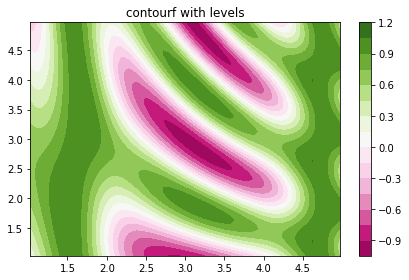

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(1, 5 + dy, dy),
                slice(1, 5 + dx, dx)]

print(x)
print(y)
z = np.sin(x)**10 + np.cos(10 + y*x) * np.cos(x)

print(z)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('PiYG')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(nrows=1)


# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., z, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

In [ ]:
import config as cf

"""Utility class used to store local traces."""
class Tracer(dict):
  def __init__(self):
    rounds_label           = 'Rounds'

    # every tuple has a y-axis label, x-axis label, list with values,
    # boolean that indicates if it is plotable and if is printable

    # lifetime/energy-related log
    self['alive_nodes']     = ('Number of alive nodes', rounds_label, [], 1, 0)
    if cf.TRACE_ENERGY:
      self['energies']        = ('Energy (J)'           , rounds_label, [], 1, 0)

    self['first_depletion'] = ('First depletion'       , rounds_label, [], 0, 0)
    self['30per_depletion'] = ('30 percent depletion'  , rounds_label, [], 0, 0)

    # coverage-related log
    self['coverage']        = ('Coverate rate'        , rounds_label, [], 0, 1)
    self['overlapping']     = ('Overlapping rate'     , rounds_label, [], 0, 1)
    self['nb_sleeping']     = ('% of sleeping nodes'  , rounds_label, [], 0, 1)

    # learning-related log
    self['initial_fitness'] = ('Initial learning'     , rounds_label, [], 0, 1)
    self['final_fitness']   = ('Final learning'       , rounds_label, [], 0, 1)

    self['term1_initial']   = ('term1 learning'       , rounds_label, [], 0, 1)
    self['term2_initial']   = ('term2 learning'       , rounds_label, [], 0, 1)
    self['term1_final']     = ('term1 final'          , rounds_label, [], 0, 1)
    self['term2_final']     = ('term2 final'          , rounds_label, [], 0, 1)


In [6]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import os
import time
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

import config as cf
from python.network.network import *


plt.rcParams.update({'font.size': 14})

def calculate_nb_clusters(avg_distance_to_BS):
  """Calculate the optimal number of clusters for FCM."""
  term1 = math.sqrt(cf.NB_NODES)/(math.sqrt(2*math.pi))
  term2 = cf.THRESHOLD_DIST
  term3 = cf.AREA_WIDTH/(avg_distance_to_BS**2)
  return int(term1*term2*term3)

def calculate_distance(node1, node2):
  """Calculate the Euclidean distance between two nodes."""
  x1 = node1.pos_x
  y1 = node1.pos_y
  x2 = node2.pos_x
  y2 = node2.pos_y
  return calculate_distance_point(x1, y1, x2, y2)

def calculate_distance_point(x1, y1, x2, y2):
  """Calculate the Euclidean distance between two points."""
  return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def print_positions(nodes):
  # check positions
  for node in nodes:
    print("%d %d" %(node.pos_x, node.pos_y))

def plot_curves(curves):
  """Generic plotter of curves."""
  assert len(curves) <= 7, "More plots (%d) than colors." %len(curves)

  colors = ['b-', 'r-', 'k-', 'y-', 'g-', 'c-', 'm-']
  color_idx = 0
  for scenario, curve in curves.iteritems():
    X = range(0, len(curve))
    plt.plot(X, curve, colors[color_idx], label=scenario)
    color_idx += 1
  plt.show()

def save2csv_raw(traces):
  to_csv = []
  dir_path = cf.RESULTS_PATH + time.strftime("%Y-%m-%d_%H:%M:%S") + '/'
  os.makedirs(dir_path)
  for scenario_name, tracer in traces.iteritems():
    for i, val in enumerate(tracer['coverage'][2]):
      tmp = {'cov' : val,
             'sleep' : tracer['nb_sleeping'][2][i]}
      to_csv.append(tmp)

    df = pd.DataFrame(to_csv)
    df.to_csv(dir_path + scenario_name + '-cov_vs_sleeping.csv')

def print_coverage_info(traces):
  for scenario_name, tracer in traces.iteritems():
    args = (scenario_name, tracer['first_depletion'][2][0])
    print("%s: first depletion at %d" % args)
    args = (scenario_name, tracer['30per_depletion'][2][0])
    print("%s: 30 percent depletion at %d" % args)
    for trace_name, trace in tracer.iteritems():
      if not trace[4]:
        continue
      values = np.array(trace[2])
      mean   = np.nanmean(values)
      stdev  = np.nanstd(values)
      args   = (scenario_name, trace_name, mean, stdev)
      print("%s: %s avg (std): %f (%f)" % args)

def save2csv(traces):
  to_csv = []
  for scenario_name, tracer in traces.iteritems():
    tmp = {'scenario_name': scenario_name,
           'first_depletion': tracer['first_depletion'][2][0],
           '30per_depletion': tracer['30per_depletion'][2][0]}
    for trace_name, trace in tracer.iteritems():
      if not trace[4]:
        continue
      values = np.array(trace[2])
      mean   = np.nanmean(values)
      stdev  = np.nanstd(values)
      tmp[trace_name+ ' (mean)']  = mean
      tmp[trace_name+ ' (stdev)'] = stdev

    to_csv.append(tmp)

  df = pd.DataFrame(to_csv)
  dir_path = cf.RESULTS_PATH + time.strftime("%Y-%m-%d_%H:%M:%S") + '/'
  os.makedirs(dir_path)
  df.to_csv(dir_path + 'results_summary.csv')

def plot_traces(traces):
  first_tracer = traces.itervalues().next()
  nb_columns   = len([1 for k, v in first_tracer.iteritems() if v[3]])
  fig, ax      = plt.subplots(nrows=1, ncols=nb_columns)

  colors = ['b', 'r', 'k', 'y', 'g', 'c', 'm']
  line_style = ['-', '--', '-.', ':']

  color_idx = 0
  line_idx  = 0
  for scenario, tracer in traces.iteritems():
    subplot_idx = 1
    for trace_name, trace in tracer.iteritems():
      if not trace[3]:
        continue
      ax = plt.subplot(1, nb_columns, subplot_idx)
      #ax.set_title(trace_name)
      X = range(0, len(trace[2]))
      color_n_line = colors[color_idx] + line_style[line_idx]
      plt.plot(X, trace[2], color_n_line, label=scenario)
      plt.xlabel(trace[1])
      plt.ylabel(trace[0])
      plt.legend(fontsize=11)
      subplot_idx += 1
    color_idx = (color_idx+1)%len(colors)
    line_idx  = (line_idx+1)%len(line_style)

  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.grid(b=True, which='major', color='0.6', linestyle='--')
  plt.show()

def plot_nodes_plane(nodes):
  X_ch = [node.pos_x for node in nodes if node.is_head()]
  Y_ch = [node.pos_y for node in nodes if node.is_head()]
  X_or = [node.pos_x for node in nodes if node.is_ordinary()]
  Y_or = [node.pos_y for node in nodes if node.is_ordinary()]
  X_de = [node.pos_x for node in nodes if not node.alive]
  Y_de = [node.pos_y for node in nodes if not node.alive]

  plt.scatter(X_ch, Y_ch, color='b')
  plt.scatter(X_or, Y_or, color='r')
  plt.scatter(X_de, Y_de, color='k')
  plt.show()

def plot_clusters(network):
  colors = ['b', 'k', 'y', 'g', 'm', 'c']
  # print clusters
  plt.figure()
  for cluster_id in range(0, cf.NB_CLUSTERS):
    cluster = network.get_nodes_by_membership(cluster_id, only_alives=0)
    X = [node.pos_x for node in cluster if not node.is_head()]
    Y = [node.pos_y for node in cluster if not node.is_head()]
    color_ref = float(cluster_id)/cf.NB_CLUSTERS*0.6
    plt.scatter(X, Y, color=colors[cluster_id%len(colors)])

  x_border = [0.0 for y in range(0, int(cf.AREA_LENGTH))]
  y_border = [y   for y in range(0, int(cf.AREA_LENGTH))]
  x_border.extend([cf.AREA_WIDTH  for y in range(0, int(cf.AREA_LENGTH))])
  y_border.extend([y              for y in range(0, int(cf.AREA_LENGTH))])
  x_border.extend([x              for x in range(0, int(cf.AREA_WIDTH))])
  y_border.extend([0.0            for x in range(0, int(cf.AREA_WIDTH))])
  x_border.extend([x              for x in range(0, int(cf.AREA_WIDTH))])
  y_border.extend([cf.AREA_LENGTH for x in range(0, int(cf.AREA_WIDTH))])
  z_border = [0 for x in range(0, int(2*cf.AREA_LENGTH + 2*cf.AREA_WIDTH))]
  for cluster_id in range(0, cf.NB_CLUSTERS):
    X = [node.pos_x for node in network[0:-1]]
    Y = [node.pos_y for node in network[0:-1]]
    Z = [1 if node.membership==cluster_id else 0 for node in network[0:-1]]
    X, Y, Z = grid(X, Y, Z)
    plt.contour(X, Y, Z, 1, colors='0.6')

  # print centroids
  #heads = network.get_heads(only_alives=0)
  heads = [x for x in network.centroids]
  X = [node.pos_x for node in heads]
  Y = [node.pos_y for node in heads]
  plt.scatter(X, Y, color='r', marker='^', s=80)

  # print BS
  X = [network.get_BS().pos_x]
  Y = [network.get_BS().pos_y]
  plt.scatter(X, Y, color='r', marker='x', s=80)

  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlim(xmax=cf.AREA_WIDTH)
  plt.ylim(ymax=cf.AREA_LENGTH)
  plt.show()

def plot_time_of_death(network):
  """Plot time of death as a colormap."""
  x = [node.pos_x for node in network[0:-1]]
  y = [node.pos_y for node in network[0:-1]]
  z = [node.time_of_death for node in network[0:-1]]

  X, Y, Z = grid(x, y, z)
  c = plt.contourf(X, Y, Z)
  cbar = plt.colorbar(c)
  cbar.ax.set_ylabel('number of rounds until full depletion')

  # print centroids
  #heads = network.get_heads(only_alives=0)
  heads = [x for x in network.centroids]
  X = [node.pos_x for node in heads]
  Y = [node.pos_y for node in heads]
  plt.scatter(X, Y, color='r', marker='^', s=80)

  # print BS
  X = [network.get_BS().pos_x]
  Y = [network.get_BS().pos_y]
  plt.scatter(X, Y, color='r', marker='x', s=80)

  # plot nodes
  for cluster_id in range(0, cf.NB_CLUSTERS):
    cluster = network.get_nodes_by_membership(cluster_id, only_alives=0)
    X = [node.pos_x for node in cluster if not node.is_head()]
    Y = [node.pos_y for node in cluster if not node.is_head()]
    color_ref = float(cluster_id)/cf.NB_CLUSTERS*0.6
    plt.scatter(X, Y, color='0.6')

  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlim(xmax=cf.AREA_WIDTH)
  plt.ylim(ymax=cf.AREA_LENGTH)

  plt.show()

def log_curves(curves):
  """Write results."""
  dir_path = cf.RESULTS_PATH + time.strftime("%Y-%m-%d_%H:%M:%S") + '/'
  os.makedirs(dir_path)
  
  # write alive_nodes vs round number
  df = pd.DataFrame.from_dict(curves)
  df.to_csv(dir_path + 'alive_nodes.txt')

  # write nodes position and time of death

def log_coverages(pso_wrapper):
  dir_path = cf.RESULTS_PATH + time.strftime("%Y-%m-%d_%H:%M:%S") + '/'
  os.makedirs(dir_path)
  df = pd.DataFrame.from_dict(pso_wrapper._cov_log)
  df.to_csv(dir_path + 'cov_log.txt')

def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

ImportError: cannot import name 'griddata' from 'matplotlib.mlab' (C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mlab.py)